<a href="https://colab.research.google.com/github/a-0yahya/Portfolio_A.Y/blob/main/Emotion_classification_with_PEFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import torch
import time
import json

from peft import LoraConfig, LoraModel, get_peft_model, TaskType
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# df = pd.read_csv('drive/MyDrive/dataset/all_data.csv')1
train_data = pd.read_csv('drive/MyDrive/dataset/train.csv')
val_data = pd.read_csv('drive/MyDrive/dataset/val.csv')
test_data = pd.read_csv('drive/MyDrive/dataset/test.csv')

# Length train, val, and test
print("Train: ",len(train_data))
print("Val: ",len(val_data))
print("Test: ",len(test_data))

Train:  1350
Val:  116
Test:  463


In [6]:
# ipython-input-18-c37e6184ce5d

# Instead of using df, use all the dataframes to ensure all labels are included
all_labels = pd.concat([train_data['label'], val_data['label'], test_data['label']]).unique()
tags = np.unique(all_labels)
num_labels = len(tags)
max_length = 128
label2id = {t: i for i, t in enumerate(tags)}
id2label = {i: t for i, t in enumerate(tags)}
label2id

{'Negative': 0, 'Neutral': 1, 'Positive': 2}

In [7]:

def model_init(model_name):
       global tokenizer
       global data_collator
       global tr_model
       tokenizer = AutoTokenizer.from_pretrained(model_name)

       base_model = AutoModelForSequenceClassification.from_pretrained(
           model_name,
           num_labels=num_labels,
           id2label=id2label,
           label2id=label2id
       )

       for param in base_model.parameters():
        param.requires_grad = False

    # Unfreeze the last two transformer layers
       for name, param in base_model.named_parameters():
        # Adapt this for different models
        if "transformer.layer" in name or "encoder.layer" in name:
          if name.split(".")[-2].isdigit() and int(name.split(".")[-2]) >= base_model.config.num_hidden_layers - 2:  # Adjust to get the correct layer index
                param.requires_grad = True


      #  # Freeze layers
      #  for name, param in base_model.named_parameters():
      #      if "classifier" not in name: # Only train the classifier layer
      #          param.requires_grad = False


       # Configure LoRA
       lora_config = LoraConfig(
           task_type=TaskType.SEQ_CLS,
           r=8, # Rank of the low-rank matrices
           lora_alpha=32,
           lora_dropout=0.1
       )

       # Wrap the base model with the LoRA configuration
       model = get_peft_model(base_model, lora_config)
       model.print_trainable_parameters()

       return model, tokenizer

In [8]:
def tokenize_function(examples):
    # process the input sequence
    tokenized_input = tokenizer(examples["tweet"],
                                truncation=True,
                                padding='max_length',
                                max_length=max_length)
    # process the labels
    tokenized_input['label'] = [label2id[lb] for lb in examples['label']]

    return tokenized_input


def preprocessing():
    X_train = Dataset.from_pandas(train_data)
    X_val = Dataset.from_pandas(val_data)
    X_test = Dataset.from_pandas(test_data)

    tokenized_train_data = X_train.map(tokenize_function, batched=True)
    tokenized_val_data = X_val.map(tokenize_function, batched=True)
    tokenized_test_data = X_test.map(tokenize_function, batched=True)

    return tokenized_train_data, tokenized_val_data, tokenized_test_data


def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    true_labels = [tags[l] for l in labels]
    true_predictions = [tags[pr] for pr in pred]

    report = classification_report(true_labels, true_predictions, digits=4)
    acc = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    rec = recall_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    prec = precision_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    f1 = f1_score(y_true=true_labels, y_pred=true_predictions, average="macro", zero_division=1.0)

    print("Classification Report:\n{}".format(report))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
# to generate the confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def generate_confusion_matrix(true_labels, pred_labels, num_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    labels = [id2label[i] for i in range(num_labels)]
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.yticks(rotation=0)
    plt.show()
def train_model(model_name, output_dir, learning_rate, train_batch_size, eval_batch_size, num_epochs, weight_decay):

    model, tokenizer = model_init(model_name)
    train_tokenized, val_tokenized, test_tokenized = preprocessing()

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",  # or "f1", etc.
        greater_is_better=True,
        save_total_limit=1,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        weight_decay=weight_decay,
        #push_to_hub=True, # to push to hub during the training
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    trainer.save_model(output_dir)
    #trainer.push_to_hub(commit_message="Training complete")

    # Get the evaluation results
    trainer.eval_dataset=test_tokenized
    evaluation_results = trainer.evaluate()
    print(evaluation_results)

    # make prediction on the test set
    predictions = trainer.predict(test_tokenized)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = test_tokenized["label"]

    # Generate confusion matrix
    generate_confusion_matrix(true_labels, pred_labels, num_labels)

    return trainer
def show_log_history(trainer):
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.fillna(0)
    log_history = log_history.groupby(["epoch"]).sum()

    log_history[["loss", "eval_loss"]].plot()
    plt.show()
def main(model_name, output_dir, best_params):
    start = time.time()
     # load json file containing best params
    best_params = best_params

    with open(best_params, 'r') as js:
        data = json.load(js)

    print(data)

    # define best params
    num_train_epochs = data['num_train_epochs']
    learning_rate = data['learning_rate']
    train_batch_size = data['per_device_train_batch_size']
    eval_batch_size = data['per_device_eval_batch_size']
    weight_decay = data['weight_decay']

    # training
    tr_model = train_model(model_name=model_name,
                           output_dir=output_dir,
                           learning_rate=learning_rate,
                           train_batch_size=train_batch_size,
                           eval_batch_size=eval_batch_size,
                           num_epochs=num_train_epochs,
                           weight_decay=weight_decay)

    print('Training finished!')

    show_log_history(tr_model)


    end = time.time()
    exec_time = (end - start) / 60
    print(f'Total time: {exec_time} minutes')


show the best result


In [9]:
def train_model(model_name, output_dir, learning_rate, train_batch_size, eval_batch_size, num_epochs, weight_decay):

    model, tokenizer = model_init(model_name)
    train_tokenized, val_tokenized, test_tokenized = preprocessing()

    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_strategy="epoch",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        weight_decay=weight_decay,
        load_best_model_at_end=True,

        # Add these two lines:
        metric_for_best_model="f1",  # or "f1"
        greater_is_better=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Print best checkpoint info clearly
    print("Best checkpoint:", trainer.state.best_model_checkpoint)
    print("Best metric value:", trainer.state.best_metric)

    # Save explicitly best model at end
    trainer.save_model(output_dir)

    # Evaluate on test set with best model loaded
    trainer.eval_dataset = test_tokenized
    evaluation_results = trainer.evaluate()

    print(evaluation_results)

    predictions = trainer.predict(test_tokenized)

    pred_labels = np.argmax(predictions.predictions, axis=1)

    true_labels = test_tokenized["label"]

    generate_confusion_matrix(true_labels, pred_labels, num_labels)

    return trainer


{'num_train_epochs': 8, 'learning_rate': 0.0001, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8, 'weight_decay': 0.0921104871708941}


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 110,857,734 || trainable%: 0.2681


Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

Map:   0%|          | 0/463 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-32-72d54dcdae22>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.020200,0.872966,0.655172,0.709557,0.651852,0.661242
2,0.772300,0.577620,0.784483,0.819882,0.779630,0.783072
3,0.443900,0.287791,0.879310,0.888257,0.876852,0.879034
4,0.280200,0.263289,0.896552,0.909388,0.892593,0.894927
5,0.233300,0.224306,0.922414,0.926091,0.920370,0.921808
6,0.196700,0.244827,0.922414,0.929494,0.920370,0.922622
7,0.184700,0.279192,0.913793,0.922481,0.911111,0.913472
8,0.164900,0.270376,0.905172,0.915786,0.901852,0.904244


Classification Report:
              precision    recall  f1-score   support

    Negative     0.5273    0.7250    0.6105        40
     Neutral     0.9091    0.5556    0.6897        36
    Positive     0.6923    0.6750    0.6835        40

    accuracy                         0.6552       116
   macro avg     0.7096    0.6519    0.6612       116
weighted avg     0.7027    0.6552    0.6603       116

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7045    0.7750    0.7381        40
     Neutral     1.0000    0.6389    0.7797        36
    Positive     0.7551    0.9250    0.8315        40

    accuracy                         0.7845       116
   macro avg     0.8199    0.7796    0.7831       116
weighted avg     0.8137    0.7845    0.7832       116

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8537    0.8750    0.8642        40
     Neutral     0.9667    0.8056    0.8788        36
    Po

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8940    0.9441    0.9184       143
     Neutral     0.9677    0.9202    0.9434       163
    Positive     0.9236    0.9236    0.9236       157

    accuracy                         0.9287       463
   macro avg     0.9284    0.9293    0.9284       463
weighted avg     0.9300    0.9287    0.9289       463

{'eval_loss': 0.18743112683296204, 'eval_accuracy': 0.9287257019438445, 'eval_precision': 0.9284495165213668, 'eval_recall': 0.9292894072699474, 'eval_f1': 0.9284434841115873, 'eval_runtime': 3.4593, 'eval_samples_per_second': 133.844, 'eval_steps_per_second': 16.767, 'epoch': 8.0}
Classification Report:
              precision    recall  f1-score   support

    Negative     0.8940    0.9441    0.9184       143
     Neutral     0.9677    0.9202    0.9434       163
    Positive     0.9236    0.9236    0.9236       157

    accuracy                         0.9287       463
   macro avg     0

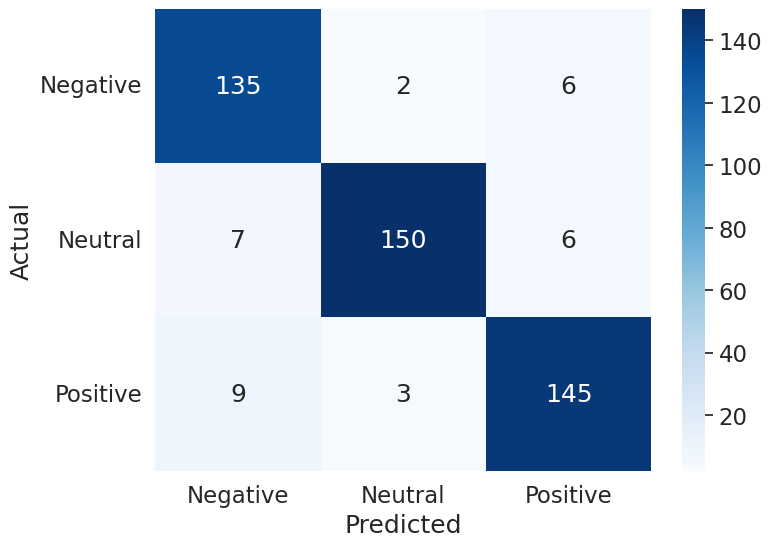

Training finished!


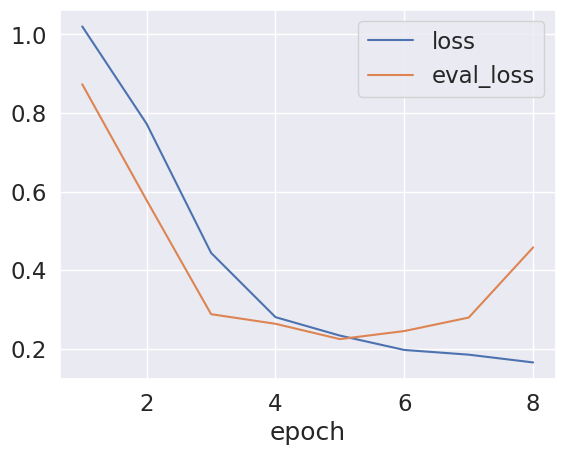

Total time: 3.0246739824612936 minutes


In [ ]:
#1 IndoBERTweet peft

main(
    model_name = 'indolem/indobertweet-base-uncased',
    output_dir = 'p-emotcls-indobertweet-base',
    best_params = 'drive/MyDrive/best_params/p-indobertweet.json'
)

{'num_train_epochs': 10, 'learning_rate': 0.0003, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8, 'weight_decay': 0.05332656928607487}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,839,107 || all params: 561,732,614 || trainable%: 0.3274


Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

Map:   0%|          | 0/463 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-af628499038e>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abdullahalsbah (abdullahalsbah-universitas-islam-indonesia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.069500,0.867323,0.568966,0.609962,0.572222,0.550309
2,0.613500,0.250441,0.922414,0.923320,0.923148,0.923139
3,0.326400,0.193829,0.922414,0.924649,0.922222,0.922772
4,0.222500,0.289293,0.922414,0.925633,0.921296,0.922649
5,0.193400,0.332001,0.922414,0.930206,0.924074,0.921689
6,0.136100,0.302087,0.931034,0.937474,0.930556,0.931048
7,0.077200,0.295668,0.931034,0.935936,0.931481,0.930534
8,0.067600,0.238453,0.931034,0.934656,0.930556,0.930602
9,0.055800,0.275363,0.939655,0.947513,0.938889,0.940606
10,0.036200,0.279148,0.939655,0.946998,0.939815,0.940437


Classification Report:
              precision    recall  f1-score   support

    Negative     0.6250    0.2500    0.3571        40
     Neutral     0.7273    0.6667    0.6957        36
    Positive     0.4776    0.8000    0.5981        40

    accuracy                         0.5690       116
   macro avg     0.6100    0.5722    0.5503       116
weighted avg     0.6059    0.5690    0.5453       116

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9231    0.9000    0.9114        40
     Neutral     0.9444    0.9444    0.9444        36
    Positive     0.9024    0.9250    0.9136        40

    accuracy                         0.9224       116
   macro avg     0.9233    0.9231    0.9231       116
weighted avg     0.9226    0.9224    0.9224       116

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9474    0.9000    0.9231        40
     Neutral     0.9429    0.9167    0.9296        36
    Po

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8940    0.9441    0.9184       143
     Neutral     0.9868    0.9141    0.9490       163
    Positive     0.9255    0.9490    0.9371       157

    accuracy                         0.9352       463
   macro avg     0.9354    0.9357    0.9348       463
weighted avg     0.9373    0.9352    0.9355       463

{'eval_loss': 0.4527260661125183, 'eval_accuracy': 0.9352051835853131, 'eval_precision': 0.9354201801653573, 'eval_recall': 0.9357369864970194, 'eval_f1': 0.9348396170550101, 'eval_runtime': 10.8932, 'eval_samples_per_second': 42.504, 'eval_steps_per_second': 5.324, 'epoch': 10.0}
Classification Report:
              precision    recall  f1-score   support

    Negative     0.8940    0.9441    0.9184       143
     Neutral     0.9868    0.9141    0.9490       163
    Positive     0.9255    0.9490    0.9371       157

    accuracy                         0.9352       463
   macro avg     0.

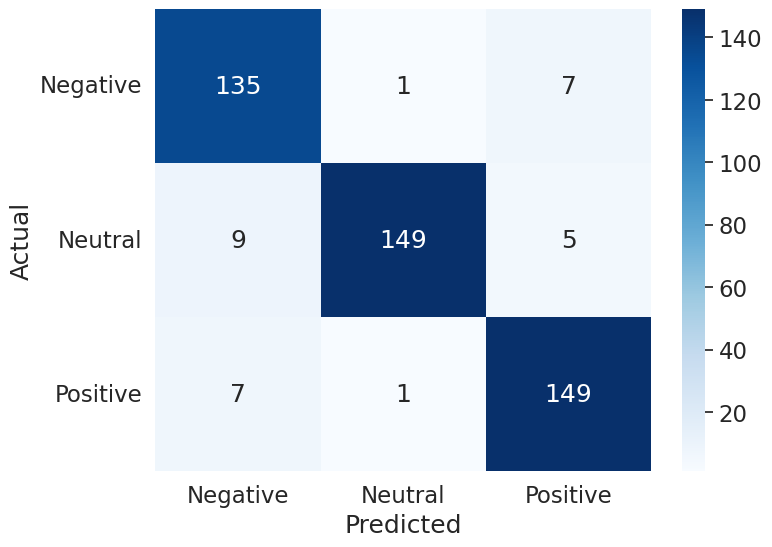

Training finished!


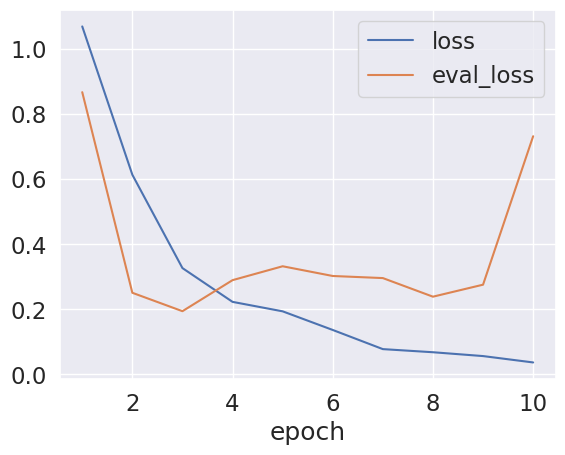

Total time: 12.586819120248158 minutes


In [10]:
#2 FacebookAI/xlm-roberta-large peft

main(
    model_name = 'FacebookAI/xlm-roberta-large',
    output_dir = 'p-emotcls-xlm-r-large',
    best_params = 'drive/MyDrive/best_params/p-xlm-r-large.json'
)

{'num_train_epochs': 9, 'learning_rate': 0.0003, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 64, 'weight_decay': 0.02768291410901637}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,811 || all params: 278,933,766 || trainable%: 0.3183


Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

Map:   0%|          | 0/463 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-af628499038e>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.095200,0.960325,0.672414,0.762854,0.665741,0.666843
2,0.741800,0.392892,0.836207,0.862986,0.834259,0.838045
3,0.478800,0.258070,0.887931,0.887789,0.887963,0.885986
4,0.358700,0.221286,0.931034,0.929990,0.930556,0.930167
5,0.278000,0.202882,0.931034,0.929990,0.930556,0.930167
6,0.239600,0.232456,0.931034,0.935936,0.931481,0.930534
7,0.198800,0.174903,0.948276,0.948221,0.949074,0.948538
8,0.204300,0.223768,0.913793,0.921223,0.912963,0.913498
9,0.188000,0.161938,0.956897,0.956837,0.956481,0.956257


Classification Report:
              precision    recall  f1-score   support

    Negative     0.8000    0.6000    0.6857        40
     Neutral     0.9444    0.4722    0.6296        36
    Positive     0.5441    0.9250    0.6852        40

    accuracy                         0.6724       116
   macro avg     0.7629    0.6657    0.6668       116
weighted avg     0.7566    0.6724    0.6681       116

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7170    0.9500    0.8172        40
     Neutral     0.9032    0.7778    0.8358        36
    Positive     0.9688    0.7750    0.8611        40

    accuracy                         0.8362       116
   macro avg     0.8630    0.8343    0.8380       116
weighted avg     0.8616    0.8362    0.8381       116

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9143    0.8000    0.8533        40
     Neutral     0.8421    0.8889    0.8649        36
    Po

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8630    0.8811    0.8720       143
     Neutral     0.9732    0.8896    0.9295       163
    Positive     0.8750    0.9363    0.9046       157

    accuracy                         0.9028       463
   macro avg     0.9037    0.9023    0.9020       463
weighted avg     0.9059    0.9028    0.9033       463

{'eval_loss': 0.31995195150375366, 'eval_accuracy': 0.9028077753779697, 'eval_precision': 0.9037226870154148, 'eval_recall': 0.9023317219167323, 'eval_f1': 0.9020249608138883, 'eval_runtime': 3.0418, 'eval_samples_per_second': 152.214, 'eval_steps_per_second': 2.63, 'epoch': 9.0}
Classification Report:
              precision    recall  f1-score   support

    Negative     0.8630    0.8811    0.8720       143
     Neutral     0.9732    0.8896    0.9295       163
    Positive     0.8750    0.9363    0.9046       157

    accuracy                         0.9028       463
   macro avg     0.9

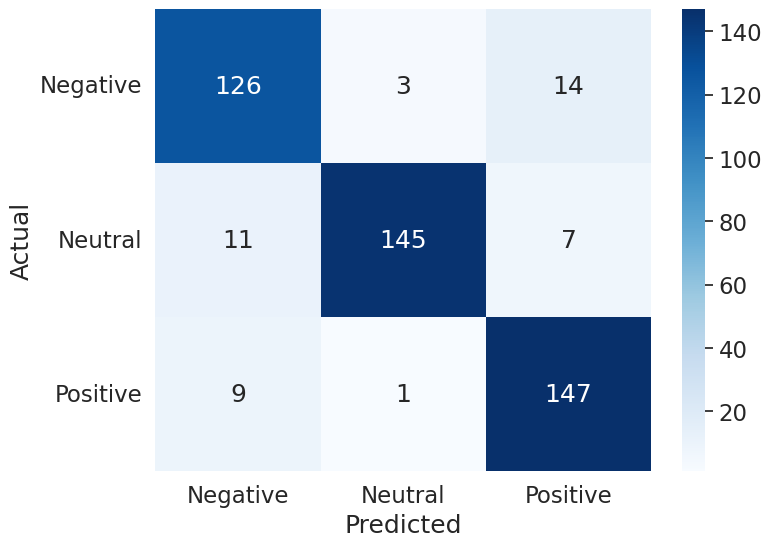

Training finished!


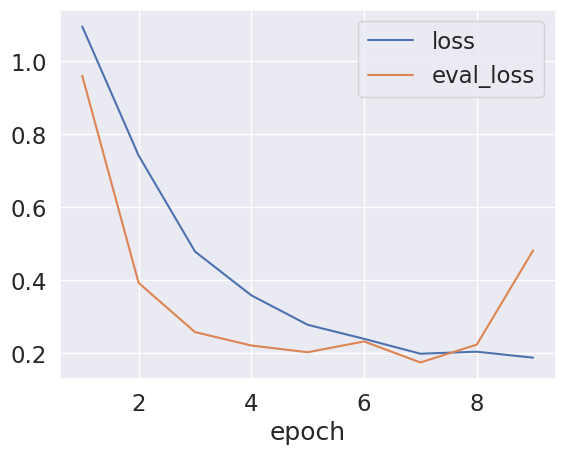

Total time: 3.3201298832893373 minutes


In [11]:
#3 FacebookAI/xlm-roberta-base peft

main(
    model_name = 'FacebookAI/xlm-roberta-base',
    output_dir = 'p-emotcls-xlm-r-base',
    best_params = 'drive/MyDrive/best_params/p-xlm-r-base.json'
)

{'num_train_epochs': 10, 'learning_rate': 0.0001, 'per_device_train_batch_size': 32, 'per_device_eval_batch_size': 32, 'weight_decay': 0.07667430551681942}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 167,655,942 || trainable%: 0.1773


Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

Map:   0%|          | 0/463 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-af628499038e>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.097700,1.075901,0.482759,0.322917,0.466667,0.380713
2,1.077400,1.038195,0.456897,0.321189,0.441667,0.348148
3,1.010500,0.899232,0.568966,0.707512,0.551852,0.474855
4,0.923500,0.811620,0.706897,0.744371,0.701852,0.701998
5,0.814400,0.722593,0.750000,0.759245,0.748148,0.749838
6,0.739000,0.644774,0.758621,0.761426,0.758333,0.759303
7,0.674600,0.592352,0.801724,0.816159,0.800000,0.803888
8,0.633800,0.554180,0.784483,0.789096,0.783333,0.784910
9,0.607900,0.541887,0.793103,0.797159,0.791667,0.792880
10,0.600600,0.537233,0.801724,0.804978,0.800000,0.801173


Classification Report:
              precision    recall  f1-score   support

    Negative     0.5000    0.6500    0.5652        40
     Neutral     0.0000    0.0000    0.0000        36
    Positive     0.4688    0.7500    0.5769        40

    accuracy                         0.4828       116
   macro avg     0.3229    0.4667    0.3807       116
weighted avg     0.3341    0.4828    0.3938       116



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report:
              precision    recall  f1-score   support

    Negative     0.5333    0.4000    0.4571        40
     Neutral     0.0000    0.0000    0.0000        36
    Positive     0.4302    0.9250    0.5873        40

    accuracy                         0.4569       116
   macro avg     0.3212    0.4417    0.3481       116
weighted avg     0.3323    0.4569    0.3602       116



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report:
              precision    recall  f1-score   support

    Negative     0.5690    0.8250    0.6735        40
     Neutral     1.0000    0.0556    0.1053        36
    Positive     0.5536    0.7750    0.6458        40

    accuracy                         0.5690       116
   macro avg     0.7075    0.5519    0.4749       116
weighted avg     0.6974    0.5690    0.4876       116

Classification Report:
              precision    recall  f1-score   support

    Negative     0.6207    0.9000    0.7347        40
     Neutral     0.8696    0.5556    0.6780        36
    Positive     0.7429    0.6500    0.6933        40

    accuracy                         0.7069       116
   macro avg     0.7444    0.7019    0.7020       116
weighted avg     0.7401    0.7069    0.7028       116

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7838    0.7250    0.7532        40
     Neutral     0.8065    0.6944    0.7463        36
    Po

Classification Report:
              precision    recall  f1-score   support

    Negative     0.5598    0.7203    0.6300       143
     Neutral     0.8062    0.6380    0.7123       163
    Positive     0.6000    0.5732    0.5863       157

    accuracy                         0.6415       463
   macro avg     0.6553    0.6439    0.6429       463
weighted avg     0.6602    0.6415    0.6442       463

{'eval_loss': 0.7866765856742859, 'eval_accuracy': 0.6414686825053996, 'eval_precision': 0.6553280530277497, 'eval_recall': 0.6438549792463277, 'eval_f1': 0.6428724681081915, 'eval_runtime': 3.288, 'eval_samples_per_second': 140.816, 'eval_steps_per_second': 4.562, 'epoch': 10.0}
Classification Report:
              precision    recall  f1-score   support

    Negative     0.5598    0.7203    0.6300       143
     Neutral     0.8062    0.6380    0.7123       163
    Positive     0.6000    0.5732    0.5863       157

    accuracy                         0.6415       463
   macro avg     0.6

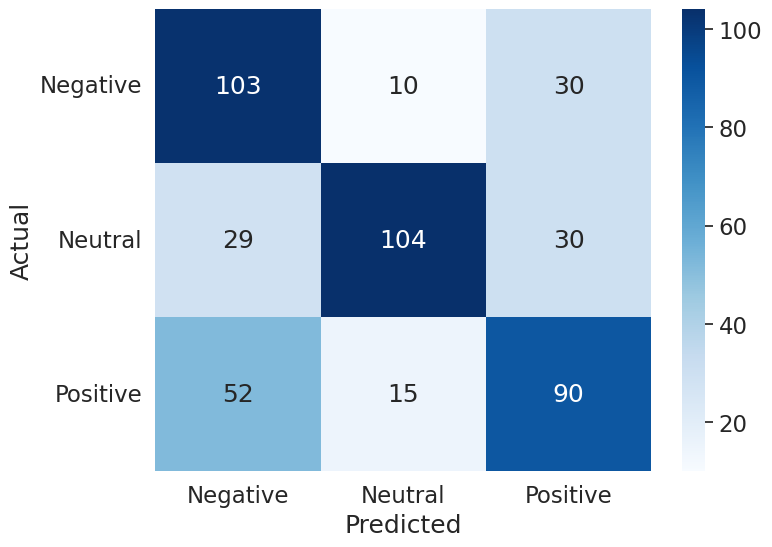

Training finished!


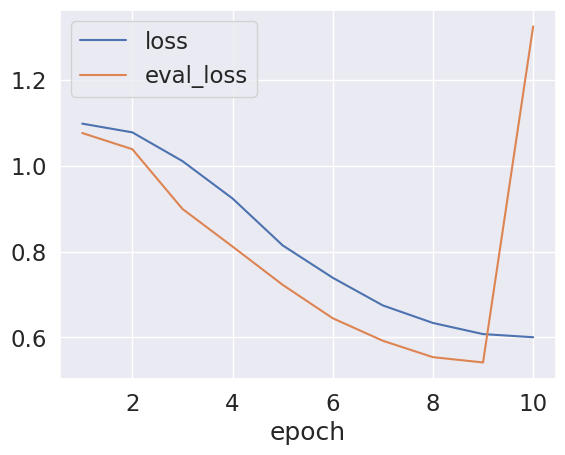

Total time: 3.435215334097544 minutes


In [15]:
#4 google-bert/bert-base-multilingual-cased peft

main(
    model_name = 'google-bert/bert-base-multilingual-uncased',
    output_dir = 'p-emotcls-bert-base',
    best_params = 'drive/MyDrive/best_params/p-mbert.json'
)


In [16]:
import pandas as pd

def get_best_metrics(trainer, model_name, metric='eval_accuracy', greater_is_better=True):
    logs = pd.DataFrame(trainer.state.log_history)
    eval_logs = logs[logs[metric].notnull()]

    if greater_is_better:
        best_epoch_row = eval_logs.loc[eval_logs[metric].idxmax()]
    else:
        best_epoch_row = eval_logs.loc[eval_logs[metric].idxmin()]

    best_epoch = int(best_epoch_row['epoch'])

    return {
        'Model': model_name,
        'Epoch': best_epoch_row['epoch'],
        'Eval Loss': best_epoch_row.get('eval_loss', '-'),
        'Accuracy': best_epoch_row.get('eval_accuracy', '-'),
        'Precision': best_epoch_row.get('eval_precision', '-'),
        'Recall': best_epoch_row.get('eval_recall', '-'),
        'F1-score': best_epoch_row.get('eval_f1', '-')
    }


In [21]:
# Example trainers dictionary
trainers = {
    "BERT": trainer_bert,
    "RoBERTa": trainer_roberta,
    "DistilBERT": trainer_distilbert,
    "XLNet": trainer_xlnet
}

# Collecting best metrics for each model
best_results = []
for model_name, trainer in trainers.items():
    metrics = get_best_metrics(trainer, model_name=model_name, metric='eval_accuracy', greater_is_better=True)
    best_metrics_list.append(metrics)

# Display all results in a clear table
best_results_df = pd.DataFrame(best_metrics_list)
print("\nBest Results for Each Model:\n")
display(best_results_df)  # use print(best_results_df) if not in notebook


NameError: name 'trainer_bert' is not defined